## Introduction to Vision Transformers

Vision Transformers are a rather recent innovation in the field of Computer Vision (though in the fast-paced world of Machine Learning, they are rather old) introduced in the paper @dosovitskiy2021imageworth16x16words.

What's so special about this model is how it departs from traditional Convolutional Neural Network (CNN) type processing, and leverages ideas from Natural Language Processing - the Transformer architecture introduced in 2017 by @vaswani2023attentionneed to perform Machine Translation (an inherently language-based task).

At the heart of the Vision Transformer is the concept of self-attention. This mechanism allows the model to weigh the importance of different elements in the input, considering the global context of the data. In the case of NLP, self-attention helps the model understand the relationships between words in a sentence, regardless of their position. Similarly, in the Vision Transformer, self-attention enables the model to capture dependencies between different **patches** of an image, allowing it to learn rich and complex features that are crucial for tasks like image classification and object detection.

The coolest part of Transformers generally is its ubiquitous nature: with very minor changes (specifically just the Positional and Patch Embedding modules), we can adapt the original architecture to the world of Computer Vision. This means that the same lessons we can learn from this model can be applied just as easily to understanding models like GPT-2 and members of the LLaMA family.

In this article, we will implement a Vision Transformer from the ground up, load in weights from a pretrained checkpoint, and adapt it to a simple task of Image Classification. 

This implementation has been inspired a lot from the `timm` implementation[@rw2019timm] - many of the snippets will be similar but this simplified implementation is intended to give more flexibility in terms of tinkering with the model and bringing in your own tweaks.

In [58]:
from typing import Optional, Tuple, Callable, Optional, Type, Union
from functools import partial
from IPython.display import clear_output

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import timm

import warnings
warnings.filterwarnings('ignore')

## Getting our Data

Let's start off by bringing in our dataset that we'll be using going forward.

We could just implement the components willy-nilly but it helps to perform the forward passes on actual tensors as we go, and understand the shapes.

Let's keep it simple and use the CIFAR-100 dataset; `torchvision` makes it very easy to use.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


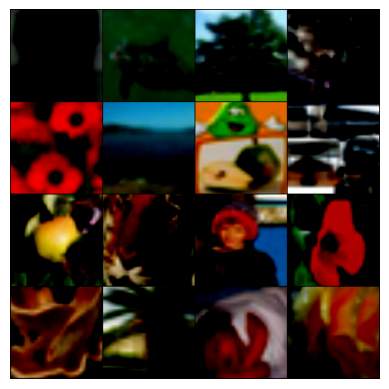

In [2]:
# Define some variables pertaining to our dataset
IMAGE_SIZE = 224
TRAIN_TFMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
TEST_TFMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def get_cifar100_dataset(root: str):
    
    trainset = datasets.CIFAR100(
        root, train=True, download=True, transform=TRAIN_TFMS
    )
    valset = datasets.CIFAR100(
        root, train=False, download=True, transform=TEST_TFMS
    )
    return trainset, valset

# Create the Dataset
train_ds, val_ds = get_cifar100_dataset("./data")

# Turn these into DataLoaders
BATCH_SIZE = 16
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
clear_output()

# Let's visualize our data for fun
grid_img = torchvision.utils.make_grid(
    tensor=next(iter(train_dl))[0], # grab a batch of images from the DataLoader
    nrow=4
)
plt.imshow(grid_img.permute(1,2,0)) # move the channel axis to the end
plt.axis(False)
plt.show()

In [3]:
# Get an instance from the dataset - returns a tuple of (input, ground truth)
x, y = train_ds[0]
print(x.shape)

torch.Size([3, 224, 224])


Some remarks about the above cells:

- The `IMAGE_SIZE` being $224$ specifically is because we will later load in a Vision Transformer checkpoint that was pretrained on images that were $(3, 224, 224)$ in shape.

- The `Resize` and `CenterCrop` combination here is a common technique for processing images into a specific size.

- The `Normalize` transform's values for the mean and standard deviation looks rather strange, but it again follows what the checkpoint we will load in later was trained on. This is rather irritating since the statistics from the ImageNet dataset are very different, so this feels a bit of an anomaly in some ways.

## Embedding an Input Image

To leverage the transformer architecture for images, we first need to convert an image into a format that the model can process, similar to how words are tokenized and embedded in NLP tasks. This process involves dividing the image into smaller, non-overlapping patches and then embedding these patches into vectors—a step analogous to generating token embeddings from words.

Imagine an image as a grid of pixels, where each pixel carries information about color and intensity. Instead of processing the entire image at once, the Vision Transformer **splits the image into fixed-size patches**, treating each patch as a "token" in the sequence. For instance, an image of size $(224,224)$ pixels could be divided into patches of size $(16,16)$, resulting in a grid of $(14 \times 14)$ patches if each patch is also $(16,16)$ pixels. This transformation effectively turns a 2D image into a 1D sequence of patches, where each patch contains a small portion of the image's data.

Once the image is divided into patches, the next step is to **embed each patch into a vector space** that the transformer can work with. This is where convolutional layers come into play. By applying a convolutional layer with an appropriate kernel size and stride, we can extract features from each patch and represent these features as embedding vectors. Each embedding vector corresponds to a specific patch and captures its local information—such as edges, textures, and colors—while also compressing the data into a more manageable form for the transformer.

This patch embedding process is akin to the embedding of words in NLP. Just as words are embedded into vectors that encapsulate their semantic meaning, image patches are embedded into vectors that represent visual features. These embeddings are then fed into the transformer model, which applies self-attention to learn relationships and dependencies between different parts of the image. This enables the Vision Transformer to understand the global structure of the image, recognizing patterns and objects in a manner similar to how it understands sentences in language tasks.

TLDR:
- The Vision Transformer can treat an image as a sequence of **fixed-size patches**.

- Each patch is converted into a **feature vector**, and this is easily done using convolutional layers.

In [4]:
PATCH_SIZE = 16

# Let's explore how we end up with 14x14 patches with the hyperparameters defined so far
number_of_patches = int((IMAGE_SIZE**2) / PATCH_SIZE**2)
print(f"Using {PATCH_SIZE=}, we get {number_of_patches=} for each channel.")
print(f"This is what we expected as {14*14=}.")

Using PATCH_SIZE=16, we get number_of_patches=196 for each channel.
This is what we expected as 14*14=196.


In [5]:
# Now if we consider the output as a long sequence of patches, we can compute the expected output shape
print(f"Original input shape: {x.shape}")

patchified = x.contiguous().view(number_of_patches, -1)
print(f"Transformed input shape: {patchified.shape}")

Original input shape: torch.Size([3, 224, 224])
Transformed input shape: torch.Size([196, 768])


### Using Convolutions to Generate Patch Embeddings

Recall that to convert our image into a sequence of patch embeddings, we need to:

1. Generate fixed-size patches from the image.
2. Embed these patches into a vector space.

We can achieve both of these steps in one go using `nn.Conv2d`.

If the convolution operation consists of a kernel of size $(k, k)$ and a stride of $k$, it effectively breaks the input image into non-overlapping patches of size $k \times k$. The kernel, also known as the filter, slides across the image, covering different sections, or patches, of the input. At each position, the kernel performs a dot product between the filter weights and the corresponding input pixels, followed by summing these products and applying an activation function. The output from each position becomes an element in the resulting feature map.

In this context, the filter's role is twofold. First, it serves as a mechanism for slicing the image into smaller patches, with each patch being a subset of the image's pixel data. Second, the convolution operation inherently compresses and transforms these patches into a set of feature maps, which can be interpreted as the patch embeddings. By adjusting the kernel size and stride, we control the size of the patches and the level of overlap between them.

For example, using a kernel size of $k = 16$ and stride $s = 16$ on an image of size $224 \times 224$ will produce a grid of $14 \times 14$ patches, each of size $16 \times 16$. The convolutional layer outputs a feature map for each filter used, where each feature map represents a different aspect of the image's data, such as edges, textures, or colors. The depth of the feature map, determined by the number of filters, defines the dimension of the patch embedding vectors.

Thus, using `nn.Conv2d`, we efficiently transform the input image into a sequence of patch embeddings, with each embedding vector encapsulating the salient features of its corresponding image patch.

In [6]:
# Create the patchifier
patchifier = nn.Conv2d(in_channels=3,
                       out_channels=768, # as we computed above
                       kernel_size=PATCH_SIZE,
                       stride=PATCH_SIZE,
                       padding=0                       
)

# Transform a batch of inputs to see how it works
x, _ = next(iter(train_dl))
out = patchifier(x)

print(f"Input shape: {x.shape}")
print(f"Patchified shape: {out.shape}")

Input shape: torch.Size([16, 3, 224, 224])
Patchified shape: torch.Size([16, 768, 14, 14])


**Quick note about the shape:**

$$(16, 768, 14, 14)$$
$$\text{(batch size, embedding dim, number of patches horizontally, number of patches vertically)}$$

Since we want to treat this as a sequence, i.e. losing the 2D structure, we can simply flatten this along the last two axes.

We will also transpose the tensor so that we have the number of channels/features at the end, this is just convention.

In [7]:
patch_emb = out.flatten(start_dim=2).transpose(1, 2) # NCHW -> NLC
print(f"Final shape: {patch_emb.shape}")

Final shape: torch.Size([16, 196, 768])


Before moving forward, another important point to note is how we will incorporate a "CLS token" or "classification token" later on for our task of image classification.

This is a technique borrowed from BERT [@devlin2019bertpretrainingdeepbidirectional], where you have a learnable embedding meant to represent the entire input sequence. In the context of the Vision Transformer, the CLS token is a special token added to the sequence of patch embeddings. It serves as a summary or a representation of the entire image. The model learns this token's embedding along with the patch embeddings during training.

At the end of the transformer layers, the CLS token's final embedding is used as the input to a classification head, typically a fully connected layer, to predict the class label. This approach allows the model to consider the entire image's context when making a classification decision, leveraging the self-attention mechanism to gather information from all patches into this single, informative vector.

<div style="text-align: center;">
  <img src="vit.png" alt="vit-layout" style="width:50%;">
</div>

In [8]:
# Quick demonstration of prepending a learnable embedding to this activation (along the "patch length" axis)
cls_token = nn.Parameter(
    torch.zeros(1, 1, 768) # channels-last
)

toks = torch.cat([
    cls_token.expand(BATCH_SIZE, -1, -1), # have to expand out the batch axis
    patch_emb,
], dim=1)

print(f"Final shape of embeddings with the CLS token: {toks.shape}")

Final shape of embeddings with the CLS token: torch.Size([16, 197, 768])


### Explicitly adding in positional information

Self-attention, while powerful, is inherently **permutation invariant**. This means that it does not take into account the order of the patches, treating them as a set rather than a sequence. However, in vision tasks, the spatial arrangement of patches is crucial for understanding the structure and relationships within an image.

To address this, we introduce positional encodings or embeddings. These are additional vectors added to the patch embeddings to inject information about the relative or absolute position of each patch in the image. In our implementation, we'll use a set of learnable weights for these positional encodings, allowing the model to learn the most effective way to incorporate positional information during training.

By combining these positional encodings with the patch embeddings, we create a richer input representation that not only captures the visual content of the patches but also their spatial arrangement. This enriched input is then fed into the next main component of the transformer, enabling the model to leverage both the content and the position of patches for more accurate understanding and processing of the image.

In the cell below, note how we use `nn.Parameter` to intialize the tensor and the shape following the patch embeddings. We rely on broadcasting to create copies over the batch axis since we do not want there to be different positional encodings for elements in different batches (that would make no sense).

In [9]:
# Initialize a randomly initialized set of positional encodings
pos_embed = nn.Parameter(torch.randn(1, toks.shape[1], toks.shape[2]) * 0.02) # this factor is from the timm implementation
x = toks + pos_embed

print(f"Final shape of input: {x.shape}")

Final shape of input: torch.Size([16, 197, 768])


## Multi-Head Self Attention

Self-attention is a fundamental mechanism in the Vision Transformer that enables patches, or tokens, to communicate with one another across the entire image. This mechanism allows each patch to consider the information from all other patches, effectively sharing and enriching the context of each patch's representation. In the scene of computer vision, this means that the model can capture relationships and dependencies between different parts of the image, such as identifying that certain shapes or colors in one part of the image may relate to features in another part. This global interaction helps the model build a more comprehensive understanding of the image, crucial for tasks like image classification.

The Self-Attention mechanism can be expressed with the following expression from @vaswani2023attentionneed:
$$\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right)V$$

Here, the components are:

- Queries ($Q$): These represent the specific aspects or "questions" that each patch wants to know about other patches.
- Keys ($K$): These act like tags or "keywords" that help identify relevant information in the patches.
- Values ($V$): These are the actual data or "answers" that the patches contain.

To explain with an analogy, think of queries, keys, and values as parts of a search engine system:

- **Queries** are like the search terms you enter. They specify what you're looking for.
- **Keys** are the tags or metadata associated with each document or webpage, helping to determine if a document matches a search query.
- **Values** are the actual content of the documents that are retrieved and displayed.

In the Vision Transformer, these components are extracted from the patch embeddings using learned linear transformations. The three matrices are computed as follows:
$$Q = W^Q X$$
$$K = W^K X$$
$$V = W^V X$$

where $W^Q, W^K, W^V$ are learnable weight matrices, and $X$ is the tensor corresponding to the input embeddings.

In [10]:
# Define variables before moving further
embed_dim = 768
B, P, C = x.shape

# We can use nn.Linear layers (without the bias) to perform these computations
query = nn.Linear(embed_dim, embed_dim, bias=False)
key = nn.Linear(embed_dim, embed_dim, bias=False)
value = nn.Linear(embed_dim, embed_dim, bias=False)

# Get the projections, these are the Q, K, V matrices in the equation above
q = query(x)
k = key(x)
v = value(x)

# Get the shapes
q.shape, k.shape, v.shape

(torch.Size([16, 197, 768]),
 torch.Size([16, 197, 768]),
 torch.Size([16, 197, 768]))

### The Multiple "Head(s)"

In the context of self-attention, a "head" refers to an individual attention mechanism within the multi-head attention framework. Each head operates independently, learning different aspects of the relationships between patches or tokens. By having multiple heads, the model can capture a diverse range of interactions and dependencies, enhancing its ability to understand complex patterns in the data.

Each head has its own set of learnable parameters for queries, keys, and values. The use of multiple heads allows the model to focus on different types of relationships or features in parallel. For instance, one head might learn to focus on spatial locality, while another might capture more global interactions.


Note how the `in_features` and `out_features` are the same for this setup. This actually makes it much easier for us to work with multiple heads in one go: we can partition the projections from these matrices by introducing a "head axis", this would then let us perform computations with `H` of these vectors of size `C//H` in parallel.

In [11]:
H = 12 # hyperparam from timm's implementation
head_size = C // H

# MHSA is usually implemented as such
q = query(x).view(B, P, H, head_size).transpose(1, 2) # (B, H, P, head_size)
k = key(x).view(B, P, H, head_size).transpose(1, 2) # (B, H, P, head_size)
v = value(x).view(B, P, H, head_size).transpose(1, 2) # (B, H, P, head_size)

q.shape, k.shape, v.shape

(torch.Size([16, 12, 197, 64]),
 torch.Size([16, 12, 197, 64]),
 torch.Size([16, 12, 197, 64]))

With the projections ready, we can finally implement the meat of the component: the equation.

$$\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right)V$$

Here's a few things to note:
1. $Q$ and $K$ are 4D tensors so the notion of a "tranpose" sounds rather strange. Note however, that the output we want from this operation is an **Attention Map** - a map that lays out the affinities between each and every pair of patches in the input tensor. This means what we really want is a `(B, H, P, P)` tensor - this means all we have to do is swap the last two axes of $K$ and follow the rules of Batched Matrix Multiplication.

2. The scale factor $\sqrt{d_k}$ is helpful for stable training. Without this, the activations would blow up exactly on the order of $d_k$, and this can lead to unstable gradients - so we scale everything down by this amount to end up with activations of unit-variance.

3. The Softmax here is applied on a row axis - i.e. the rows of the 2D slice must contain values that sum up to 1. This is important to note since we consider the dot product of the row of the query matrix with the columns of the transpose of the key (so if you ask a specific question following the analogy above, you'd want the answers to be weighed according to the question, not all questions weighed according to a single answer).

In [12]:
# Let's implement this all in one go

H = 12
head_size = C // H

print(f"{x.shape=}")

# MHSA is usually implemented as such
q = query(x).view(B, P, H, head_size).transpose(1, 2) # (B, H, P, head_size)
k = key(x).view(B, P, H, head_size).transpose(1, 2) # (B, H, P, head_size)
v = value(x).view(B, P, H, head_size).transpose(1, 2) # (B, H, P, head_size)

scale = q.size(-1) # the head size

q = q*scale

# Take the dot product
attn = q @ k.transpose(-2, -1) # (B, H, P, head_size) @ (B, H, head_size, P) --> (B, H, P, P)
print(f"{attn.shape=}")

# Softmax along the final axis, i.e. rows
attn = attn.softmax(dim=-1)
out = attn @ v # (B, H, P, P) @ (B, H, P, head_size) --> (B, H, P, head_size)
print(f"{out.shape=}")

# Collapse the head dimension to get back 
sa_out = out.transpose(1, 2).contiguous().view(B, P, C)
print(f"{sa_out.shape=}")

x.shape=torch.Size([16, 197, 768])
attn.shape=torch.Size([16, 12, 197, 197])
out.shape=torch.Size([16, 12, 197, 64])
sa_out.shape=torch.Size([16, 197, 768])


The shapes can help give us a very interesting interpretation of what Self-Attention really does: if the input and output shapes are exactly the same (i.e. `[16, 197, 768]`) but with so much of processing with learnable parameters in the middle, then we can think of this module as simply **refining the representations**.

To expand on this, your input is provided as a sequence of embeddings (order matters here) - the Self-Attention operation allows the elements to communicate and share information with one another, enriching each other with context, so that the final consolidated output is simply an enriched version of the input. It also helps that having the same shape allows you to stack these components on top of one another very easily, as we will see later.

### Building `MHSA`

Let's put all of these operations, with a few other bells and whistles into a single `nn.Module` class.

Note how we add two things here:
1. The `proj` component: this is a projection back into the same vector space, so it again acts like simply *refining* what you already have. Andrej Karpathy calls this as *thinking* on what you have just computed from the Self-Attention operation.

2. The `proj_drop` component: This is a form of Dropout which acts as a regularizing mechanism for the Vision Transformer. This becomes very important since they are prone to overfit on simplistic datasets, so this and `attn_drop` (functionally the same thing) can help mitigate this heinous activity.

In [46]:
class MHSA(nn.Module):

    def __init__(
            self,
            dim: int,
            num_heads: int = 8,
            qkv_bias: bool = False,
            attn_drop: float = 0.,
            proj_drop: float = 0.
    ) -> None:
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.k = nn.Linear(dim, dim, bias=qkv_bias)
        self.v = nn.Linear(dim, dim, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, P, C = x.shape
        H = self.num_heads
        q = self.q(x).view(B, P, H, -1).transpose(1, 2) # (B, H, P, head_size)
        k = self.k(x).view(B, P, H, -1).transpose(1, 2) # (B, H, P, head_size)
        v = self.v(x).view(B, P, H, -1).transpose(1, 2) # (B, H, P, head_size)
        
        q = q * self.scale

        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B, P, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [47]:
# Perform a forward pass on a dummy input
mhsa = MHSA(dim=768,
            num_heads=12,
            qkv_bias=True,
            )

# Create sample input tensor
B, P, C = 16, 196, 768
x = torch.randn(B, P, C)

# Pass the input through the MHSA layer to trigger the hook
output = mhsa(x)
print(f"{x.shape=} --> {output.shape=}")
del mhsa

x.shape=torch.Size([16, 196, 768]) --> output.shape=torch.Size([16, 196, 768])


## The "Encoder Block"

Let's go back to the main illustration in the original paper:

<div style="text-align: center;">
  <img src="vit.png" alt="vit-layout" style="width:50%;">
</div>

The grayed out block on the right side represents a single "Encoder Block".

The Encoder Block is a fundamental component of the Vision Transformer, inheriting its architecture from the original Transformer model used in natural language processing. Each Encoder Block is designed to process and refine the input sequence—here, the sequence of patch embeddings enriched with positional encodings.

The Encoder Block consists of two main sub-layers:

Multi-Head Self-Attention Mechanism: This layer allows the model to focus on different parts of the input sequence simultaneously, capturing various relationships and dependencies among the patches. As discussed earlier, multiple heads enable the model to learn different aspects of the data, providing a comprehensive representation.

**Feed-Forward Neural Network (FFN)**: Following the self-attention layer, a position-wise feed-forward neural network processes the output. This network typically consists of two linear transformations separated by a non-linear activation function, such as GeLU. It acts on each position independently and helps in further transforming and refining the representation learned from the self-attention layer.

To ensure the effective flow of gradients during training and to preserve the original input information, each sub-layer is equipped with **Skip Connections** (also known as Residual Connections). These connections add the input of each sub-layer to its output, forming a residual path that facilitates better gradient propagation and helps prevent the vanishing gradient problem. Mathematically, this can be expressed as:

$$\text{Output} = \text{Layernorm}(x + \text{SubLayer}(x))$$

In the equation above, $x$ represents the input to the sub-layer, and the sum $x + \text{SubLayer}(x)$ forms the residual connection. This is a very old idea in Deep Learning, going back to 2015 with ResNets [@he2015deepresiduallearningimage], and can perhaps be better understood with the following illustration:

<div style="text-align: center;">
  <img src="skip-connection.png" alt="skip-connection" style="width:30%;">
</div>

The output is then normalized using Layer Normalization (`LayerNorm`), which stabilizes the training by normalizing the summed outputs across each patch, ensuring that the model's activations are within a stable range. LayerNorm adjusts the output by scaling and shifting, allowing the model to maintain useful information while preventing excessive internal covariate shifts.

The Encoder Block's design, with its combination of self-attention, feed-forward neural networks, skip connections, and layer normalization, enables the Vision Transformer to learn rich, hierarchical representations of the input data. This structure is repeated multiple times in the model, each block building upon the representations learned by the previous one, gradually refining the understanding of the input image.

Let's go ahead and implement this directly.

In [48]:
class Mlp(nn.Module):
    def __init__(self, 
                 in_features: int,
                 hidden_features: int,
                 drop: float,
                 norm_layer: nn.Module = None) -> None:
        super().__init__()

        # There are two Linear layers in the conventional implementation
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, in_features)

        # Dropout is used twice, once after each linear layer
        self.drop1 = nn.Dropout(drop)
        self.drop2 = nn.Dropout(drop)

        # The paper uses the GeLU activation function
        self.act = nn.GELU()

        # Optional normalization layer (following timm's convention)
        self.norm = norm_layer(hidden_features) if norm_layer is not None else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.norm(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

class Block(nn.Module):
    def __init__(
            self,
            dim: int,
            num_heads: int,
            mlp_ratio: float = 4.,
            qkv_bias: bool = False,
            proj_drop: float = 0.,
            attn_drop: float = 0.,
    ) -> None:
        super().__init__()
        
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        self.mlp = Mlp(
            in_features=dim,
            hidden_features=int(dim * mlp_ratio),
            drop=proj_drop,
        )

        self.attn = MHSA(
            dim=dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=proj_drop
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x
    
block = Block(dim=768,
              num_heads=12)
block_out = block(x)

print(f"{x.shape=} --> {block_out.shape=}")
del block

x.shape=torch.Size([16, 196, 768]) --> block_out.shape=torch.Size([16, 196, 768])


A wonderful observation here is again that the **input and output shapes are exactly the same!**

This means we can again fall back on the interpretation that each Block (on top of each MHSA module) is simply *refining* and embedding rich context into whatever input is fed into it. 

Plus, having the same shape as the input allows us to stack these encoders nicely on top of each other without much thought or care.

## Putting it all together

Now with everything we've learned so far, let's make one final class that aggregates everything.

Recall what we had to do with

1. The Patch Embeddings to represent our image as a sequence and let Self-Attention link parts of it with one another,

2. The Positional Encodings/Embeddings to move past the permutation invariant nature of Self-Attention and embed information regarding the position of each patch into the mix,

3. The CLS Token to let the model have an overall representation of the entire image which would provide a means of performing classification,

4. The Multi-Head Self-Attention class (`MHSA`) to let the patches communicate and share information with one another in the hopes of enriching the representations,

5. The Block class (`Block`) to be able to string together the computations performed by the Self-Attention, Feedforward, and Layer Normalization modules.

Now we put it all together.

In [49]:
class PatchEmbed(nn.Module):
    def __init__(self,
                 img_size: int,
                 patch_size: int,
                 in_chans: int,
                 embed_dim: int,
                 bias: bool = True,
                 norm_layer: Optional[Callable] = None) -> None:
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size

        # self.grid_size = tuple([s // p for s, p in zip(self.img_size, self.patch_size)])
        self.grid_size = (self.img_size // self.patch_size, ) * 2
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_chans, 
                              embed_dim, 
                              kernel_size=patch_size, 
                              stride=patch_size, 
                              bias=bias, 
                              padding=0)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2) # flatten and transpose: BCHW -> BLC
        return x

In [50]:
class VisionTransformer(nn.Module):

    def __init__(
            self,
            img_size: Union[int, Tuple[int, int]] = 224,
            patch_size: Union[int, Tuple[int, int]] = 16,
            in_chans: int = 3,
            num_classes: int = 1000,
            embed_dim: int = 768,
            depth: int = 12,
            num_heads: int = 12,
            mlp_ratio: float = 4.,
            qkv_bias: bool = True,
            drop_rate: float = 0.,
            pos_drop_rate: float = 0.,
            proj_drop_rate: float = 0.,
            attn_drop_rate: float = 0.,
    ) -> None:
        """
        Args:
            img_size: Input image size.
            patch_size: Patch size.
            in_chans: Number of image input channels.
            num_classes: Number of classes for classification heads
            embed_dim: Transformer embedding dimension.
            depth: Depth of transformer.
            num_heads: Number of attention heads.
            mlp_ratio: Ratio of mlp hidden dim to embedding dim.
            qkv_bias: Enable bias for qkv projections if True.
            drop_rate: Head dropout rate.
            pos_drop_rate: Position embedding dropout rate.
            attn_drop_rate: Attention dropout rate.
        """
        super().__init__()

        self.num_classes = num_classes
        self.num_features = self.head_hidden_size = self.embed_dim = embed_dim  # for consistency with other models

        # Define the Patch Embedding module - note this does not include the CLS token yet
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            bias=True,
        )
        num_patches = self.patch_embed.num_patches
        embed_len = num_patches + 1 # don't forget we need to incorporate the CLS token

        # Define the CLS token, the Positional Encodings/Embeddings, and a Dropout for the Positional information
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, embed_len, embed_dim) * .02)
        self.pos_drop = nn.Dropout(p=pos_drop_rate)

        # Define LayerNorms for before and after the Encoder block processing
        norm_layer = partial(nn.LayerNorm, eps=1e-6)
        self.norm_pre = norm_layer(embed_dim)
        self.norm = norm_layer(embed_dim)

        # Initialize the blocks
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                proj_drop=proj_drop_rate,
                attn_drop=attn_drop_rate
            )
            for i in range(depth)])
        
        self.feature_info = [
            dict(module=f'blocks.{i}', num_chs=embed_dim) for i in range(depth)
        ]

        # Classifier Head
        self.head_drop = nn.Dropout(drop_rate)
        self.head = nn.Linear(self.embed_dim, num_classes)

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        
        # Get the Patch Embeddings
        x = self.patch_embed(x)

        # Prepend the CLS token, THEN add in the positional information
        x = torch.cat([
            self.cls_token.expand(x.shape[0], -1, -1), # have to expand out the batch axis
            x,
        ], dim=1)
        x = x + self.pos_embed

        # Pass through the LayerNorms, the Encoder Blocks, then the final Norm
        x = self.norm_pre(x)
        x = self.blocks(x)
        x = self.norm(x)

        return x

    def forward_head(self, x: torch.Tensor) -> torch.Tensor:
        
        # Get the CLS token (also called "pooling" our logits)
        x = x[:, 0]

        # Pass through the Dropout then the classification head
        x = self.head_drop(x)
        x = self.head(x)
        
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x
    
model = VisionTransformer()


In [51]:
x, _ = next(iter(train_dl))
out = model(x)
print(out.shape)

torch.Size([16, 1000])


## Loading in Pretrained Weights

Now that we've built our simplistic version of a Vision Transformer, let's load in the parameters from a pretrained checkpoint, specifically from the Base variant of the `timm` library.

The procedure is simple: load in the `state_dict` from the pretrained model, and match with the corresponding parameters in your implementation. Since we were careful to stick with a naming convention similar to the implementation already in `timm`, we've made our job simpler already.

We will do this in a slightly unconventional way - we will define methods for loading in the parameters in **each module**. This makes our code arguably more readable, but requires us to rewrite the module again for the purposes of this article (last time, promise!).

This form of matching and copying has been inspired from Sebastian Raschka's book on "LLMs from Scratch" [@build-llms-from-scratch-book], specifically [this notebook](https://github.com/rasbt/LLMs-from-scratch/blob/main/ch05/01_main-chapter-code/ch05.ipynb).

In [52]:
def assign_check(left: torch.Tensor, right: torch.Tensor):
    '''Utility for checking and creating parameters to be used in loading a pretrained checkpoint'''
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch: Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())

class PatchEmbed(nn.Module):
    def __init__(self,
                 img_size: int,
                 patch_size: int,
                 in_chans: int,
                 embed_dim: int,
                 bias: bool = True,
                 norm_layer: Optional[Callable] = None) -> None:
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size

        # self.grid_size = tuple([s // p for s, p in zip(self.img_size, self.patch_size)])
        self.grid_size = (self.img_size // self.patch_size, ) * 2
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_chans, 
                              embed_dim, 
                              kernel_size=patch_size, 
                              stride=patch_size, 
                              bias=bias, 
                              padding=0)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2) # flatten and transpose: BCHW -> BLC
        return x
    
class MHSA(nn.Module):

    def __init__(
            self,
            dim: int,
            num_heads: int = 8,
            qkv_bias: bool = False,
            attn_drop: float = 0.,
            proj_drop: float = 0.
    ) -> None:
        super().__init__()
        
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.k = nn.Linear(dim, dim, bias=qkv_bias)
        self.v = nn.Linear(dim, dim, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, P, C = x.shape
        H = self.num_heads
        q = self.q(x).view(B, P, H, -1).transpose(1, 2) # (B, H, P, head_size)
        k = self.k(x).view(B, P, H, -1).transpose(1, 2) # (B, H, P, head_size)
        v = self.v(x).view(B, P, H, -1).transpose(1, 2) # (B, H, P, head_size)
        
        q = q * self.scale

        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B, P, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
    def att_weight_conversion(self, qkv_params):
        '''
        Split and convert the QKV parameters from ViT checkpoints for the GQA implementation
        '''
        q, k, v = torch.split(qkv_params, qkv_params.shape[0] // 3, dim=0)
        
        return {
            "q": q,
            "k": k,
            "v": v
        }
    
    def load_pretrained_weights(self, state_dict, block_idx):

        # Load in parameters for the Query Key Value layers
        qkv_weight = state_dict[f'blocks.{block_idx}.attn.qkv.weight']
        qkv_bias = state_dict[f'blocks.{block_idx}.attn.qkv.bias']

        wdict = self.att_weight_conversion(qkv_weight)
        bdict = self.att_weight_conversion(qkv_bias)

        self.q.weight = assign_check(self.q.weight, wdict['q'])
        self.q.bias = assign_check(self.q.bias, bdict['q'])

        self.k.weight = assign_check(self.k.weight, wdict['k'])
        self.k.bias = assign_check(self.k.bias, bdict['k'])
        
        self.v.weight = assign_check(self.v.weight, wdict['v'])
        self.v.bias = assign_check(self.v.bias, bdict['v'])

        # Load in parameters for the output projection
        self.proj.weight = assign_check(self.proj.weight, state_dict[f'blocks.{block_idx}.attn.proj.weight'])
        self.proj.bias = assign_check(self.proj.bias, state_dict[f'blocks.{block_idx}.attn.proj.bias'])

class Mlp(nn.Module):
    def __init__(self, 
                 in_features: int,
                 hidden_features: int,
                 drop: float,
                 norm_layer: nn.Module = None) -> None:
        super().__init__()

        # There are two Linear layers in the conventional implementation
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, in_features)

        # Dropout is used twice, once after each linear layer
        self.drop1 = nn.Dropout(drop)
        self.drop2 = nn.Dropout(drop)

        # The paper uses the GeLU activation function
        self.act = nn.GELU()

        # Optional normalization layer (following timm's convention)
        self.norm = norm_layer(hidden_features) if norm_layer is not None else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.norm(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

class Block(nn.Module):
    def __init__(
            self,
            dim: int,
            num_heads: int,
            mlp_ratio: float = 4.,
            qkv_bias: bool = False,
            proj_drop: float = 0.,
            attn_drop: float = 0.,
    ) -> None:
        super().__init__()
        
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        self.mlp = Mlp(
            in_features=dim,
            hidden_features=int(dim * mlp_ratio),
            drop=proj_drop,
        )

        self.attn = MHSA(
            dim=dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=proj_drop
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x
    
    def load_pretrained_weights(self, state_dict, block_idx):

        self.attn.load_pretrained_weights(state_dict, block_idx)

        self.norm1.weight = assign_check(self.norm1.weight, state_dict[f'blocks.{block_idx}.norm1.weight'])
        self.norm1.bias = assign_check(self.norm1.bias, state_dict[f'blocks.{block_idx}.norm1.bias'])
        
        self.norm2.weight = assign_check(self.norm2.weight, state_dict[f'blocks.{block_idx}.norm2.weight'])
        self.norm2.bias = assign_check(self.norm2.bias, state_dict[f'blocks.{block_idx}.norm2.bias'])

        self.mlp.fc1.weight = assign_check(self.mlp.fc1.weight, state_dict[f'blocks.{block_idx}.mlp.fc1.weight'])
        self.mlp.fc1.bias = assign_check(self.mlp.fc1.bias, state_dict[f'blocks.{block_idx}.mlp.fc1.bias'])
        self.mlp.fc2.weight = assign_check(self.mlp.fc2.weight, state_dict[f'blocks.{block_idx}.mlp.fc2.weight'])
        self.mlp.fc2.bias = assign_check(self.mlp.fc2.bias, state_dict[f'blocks.{block_idx}.mlp.fc2.bias'])
    
class VisionTransformer(nn.Module):

    def __init__(
            self,
            img_size: Union[int, Tuple[int, int]] = 224,
            patch_size: Union[int, Tuple[int, int]] = 16,
            in_chans: int = 3,
            num_classes: int = 1000,
            embed_dim: int = 768,
            depth: int = 12,
            num_heads: int = 12,
            mlp_ratio: float = 4.,
            qkv_bias: bool = True,
            drop_rate: float = 0.,
            pos_drop_rate: float = 0.,
            proj_drop_rate: float = 0.,
            attn_drop_rate: float = 0.,
    ) -> None:
        """
        Args:
            img_size: Input image size.
            patch_size: Patch size.
            in_chans: Number of image input channels.
            num_classes: Number of classes for classification heads
            embed_dim: Transformer embedding dimension.
            depth: Depth of transformer.
            num_heads: Number of attention heads.
            mlp_ratio: Ratio of mlp hidden dim to embedding dim.
            qkv_bias: Enable bias for qkv projections if True.
            drop_rate: Head dropout rate.
            pos_drop_rate: Position embedding dropout rate.
            attn_drop_rate: Attention dropout rate.
        """
        super().__init__()

        self.num_classes = num_classes
        self.num_features = self.head_hidden_size = self.embed_dim = embed_dim  # for consistency with other models

        # Define the Patch Embedding module - note this does not include the CLS token yet
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            bias=True,
        )
        num_patches = self.patch_embed.num_patches
        embed_len = num_patches + 1 # don't forget we need to incorporate the CLS token

        # Define the CLS token, the Positional Encodings/Embeddings, and a Dropout for the Positional information
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, embed_len, embed_dim) * .02)
        self.pos_drop = nn.Dropout(p=pos_drop_rate)

        # Define LayerNorms for before and after the Encoder block processing
        norm_layer = partial(nn.LayerNorm, eps=1e-6)
        self.norm_pre = norm_layer(embed_dim)
        self.norm = norm_layer(embed_dim)

        # Initialize the blocks
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                proj_drop=proj_drop_rate,
                attn_drop=attn_drop_rate
            )
            for i in range(depth)])
        
        self.feature_info = [
            dict(module=f'blocks.{i}', num_chs=embed_dim) for i in range(depth)
        ]

        # Classifier Head
        self.head_drop = nn.Dropout(drop_rate)
        self.head = nn.Linear(self.embed_dim, num_classes)

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        
        # Get the Patch Embeddings
        x = self.patch_embed(x)

        # Prepend the CLS token, THEN add in the positional information
        x = torch.cat([
            self.cls_token.expand(x.shape[0], -1, -1), # have to expand out the batch axis
            x,
        ], dim=1)
        x = x + self.pos_embed

        # Pass through the LayerNorms, the Encoder Blocks, then the final Norm
        x = self.norm_pre(x)
        x = self.blocks(x)
        x = self.norm(x)

        return x

    def forward_head(self, x: torch.Tensor) -> torch.Tensor:
        
        # Get the CLS token (also called "pooling" our logits)
        x = x[:, 0]

        # Pass through the Dropout then the classification head
        x = self.head_drop(x)
        x = self.head(x)
        
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x
    
    def load_pretrained_weights(self, state_dict):
        
        print("Loading in weights...")
        
        for b, block in enumerate(self.blocks):
            block.load_pretrained_weights(state_dict, b)
        print(f"Finished with {b+1} blocks...")

        self.patch_embed.proj.weight = assign_check(self.patch_embed.proj.weight, state_dict['patch_embed.proj.weight'])
        self.patch_embed.proj.bias = assign_check(self.patch_embed.proj.bias, state_dict['patch_embed.proj.bias'])
        self.cls_token = assign_check(self.cls_token, state_dict['cls_token'])
        self.pos_embed = assign_check(self.pos_embed, state_dict['pos_embed'])

        print("Success!")

In [66]:
def vit_small_patch16_224(
        num_classes: int = 10,
        pretrained: bool = False,
        in_chans: int = 3,
        drop_rate: float = 0,
        pos_drop_rate: float = 0,
        attn_drop_rate: float = 0,
        proj_drop_rate: float = 0.
        ):
    
    model = VisionTransformer(
        img_size=224,
        patch_size=16,
        in_chans=in_chans,
        num_classes=num_classes,
        embed_dim=384,
        num_heads=6,
        depth=12,
        drop_rate=drop_rate,
        pos_drop_rate=pos_drop_rate,
        attn_drop_rate=attn_drop_rate,
        proj_drop_rate=proj_drop_rate
    )

    if pretrained:
        ckpt = 'vit_small_patch16_224'
        if in_chans != 3:
            raise ValueError(f"Cannot load in checkpoint with {in_chans=}")
        print(f'Using checkpoint {ckpt}...')
        hf_model = timm.create_model(ckpt, pretrained=True)
        model.load_pretrained_weights(hf_model.state_dict())
    
    return model

In [67]:
# Load in our model
model = vit_small_patch16_224(num_classes=100,
                             pretrained=True)

Using checkpoint vit_small_patch16_224...
Loading in weights...
Finished with 12 blocks...
Success!


## Finetuning our Vision Transformer

Now with everything in place, we can finally move on to actually finetuning our model.

We will use the CIFAR100 dataset since it's (arguably) rather difficult to perform well on: there's only 600 images for each of its 100 classes, so training a model from scratch would be very difficult to get to perform well on this dataset. This serves as a nice pressure test for our model, provided we did our loading of the pretrained checkpoint properly.

To spice things up, we'll add in random augmentations during the training process.

In [70]:
# Prepare CIFAR100
IMAGE_SIZE = 224
TRAIN_TFMS = transforms.Compose([
    transforms.RandAugment(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
TEST_TFMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def get_dataloader(dataset: torch.utils.data.Dataset,
                   batch_size: int,
                   is_train: bool,
                   num_workers: int = 1):
    
    loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=is_train, num_workers=num_workers)
    return loader

def get_cifar100_dataset(root: str):

    trainset = torchvision.datasets.CIFAR100(
        root, train=True, download=True, transform=TRAIN_TFMS
    )

    testset = torchvision.datasets.CIFAR100(
        root, train=False, download=True, transform=TEST_TFMS
    )

    return trainset, testset

train, val = get_cifar100_dataset("./data")
train_dl = get_dataloader(train, 32, True)
val_dl = get_dataloader(val, 32, False)

Files already downloaded and verified
Files already downloaded and verified


Now we'll define our training and validation functions. 

It's always good to make your code modular.

In [71]:
def train_step(model, dataloader, criterion, optimizer, device):
    '''Train for one epoch'''

    model.train()

    train_loss = 0.
    train_acc = 0.

    for step, (X, y) in tqdm(enumerate(dataloader), desc="Training", leave=False):
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred = torch.argmax(logits.detach(), dim=1)
        train_acc += ((y_pred == y).sum().item() / len(y))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

@torch.inference_mode()
def eval_step(model, dataloader, criterion, device):
    
    model.eval()

    eval_loss = 0.
    eval_acc = 0.

    for (X, y) in tqdm(dataloader, desc="Evaluating", leave=False):
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        eval_loss += loss.item()

        y_pred = torch.argmax(logits.detach(), dim=1)
        eval_acc += ((y_pred == y).sum().item() / len(y))

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    return eval_loss, eval_acc

Now to actually kick off training.

We'll keep things simple:
- Finetune for 3 epochs
- Use a learning rate of 0.0001
- Use the `AdamW` optimizer since this usually works well for something as annoying to train as a Vision Transformer

To speed up the training process, we'll also use `torch.compile` since our implementation is very straightforward and will not incur any nasty graph breaks or such during the compilation process.

In [72]:
learning_rate = 1e-4
epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
model = torch.compile(model)

history = {k: [] for k in ("train_loss", "train_acc", "val_loss", "val_acc")}

for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss, train_acc = train_step(model, train_dl, criterion, optimizer, device)
    val_loss, val_acc = eval_step(model, val_dl, criterion, device)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

Epochs: 100%|██████████| 3/3 [04:21<00:00, 87.07s/it] 


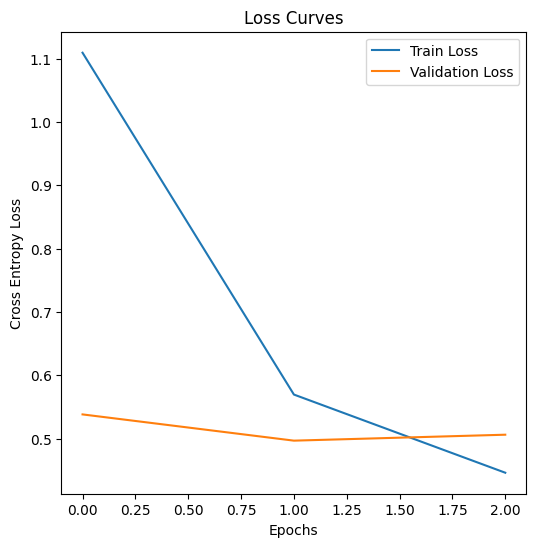

In [77]:
# Plot the loss curves
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

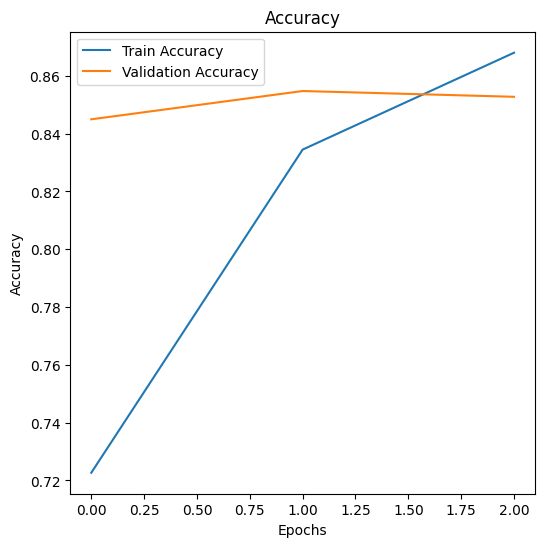

In [78]:
# Plot the loss curves
plt.figure(figsize=(6,6))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Hopefully you can appreciate what we've built together from start to end.

You can use the same type of recipe to make a BERT clone, the only real differences there would be (1) the data munging, (2) the positional encodings, and (3) the token embeddings in place of the patch embeddings. Otherwise, the same general principles would apply here and big chunks of the same code can be copied verbatim.